<a href="https://colab.research.google.com/github/eileenrmartin/IntroToDASData/blob/master/BradyHotSprings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example with Brady Hot Springs Vibroseis



The Python packages we'll use are:

*   pandas, already available in Colab
*   matplotlib.pyplot, already available in Colab
*   obspy, needs to be installed
* maybe some others**** like scipy.fftpack or numpy?*

To run a bash (command-line) command in a Jupyter notebook on Colab, use an ! before the command. Below is the command to install obspy. 



In [1]:
!pip install obspy

     |████████████████████████████████| 24.7MB 164kB/s 
  Created wheel for obspy: filename=obspy-1.2.1-cp36-cp36m-linux_x86_64.whl size=21661682 sha256=5ac9dc1d8573c8fc3587872c764a36d8dd216f12a413e9b20dc7080ea6f2bf84
  Stored in directory: /root/.cache/pip/wheels/99/1b/9d/ada1c7af86c92811628dc58568bb27f3ffb46ee157e1f1e8db
Successfully built obspy


All packages need to be imported before they can be used. Now that we've installed Obspy, let's load all relevant packages.

In [0]:
import pandas as pd
import numpy as np
import scipy.fftpack as ft
import matplotlib.pyplot as plt
import obspy
import csv
import struct

...some other stuff goes here...

# Reading Array Geometry

Grab csv (comma separated value) data from Geothermal Data Repository. File is at url: https://gdr.openei.org/files/829/Surface_DAS_DTS_UTM_coordinates.csv and more info is at https://openei.org/doe-opendata/dataset/brady-s-geothermal-field-das-and-dts-surface-and-borehole-array-metadata/resource/f0000003-58cc-4372-a567-000000000829

In [3]:
!wget https://gdr.openei.org/files/829/Surface_DAS_DTS_UTM_coordinates.csv

--2020-04-29 12:58:14--  https://gdr.openei.org/files/829/Surface_DAS_DTS_UTM_coordinates.csv
Resolving gdr.openei.org (gdr.openei.org)... 52.32.102.211, 52.24.243.44, 54.148.193.62
Connecting to gdr.openei.org (gdr.openei.org)|52.32.102.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307372 (300K) [application/octet-stream]
Saving to: ‘Surface_DAS_DTS_UTM_coordinates.csv’

Surface_DAS_DTS_UTM 100%[===================>] 300.17K  1.16MB/s    in 0.3s    

2020-04-29 12:58:14 (1.16 MB/s) - ‘Surface_DAS_DTS_UTM_coordinates.csv’ saved [307372/307372]



Read the geometry data:

In [0]:
geomData = 'Surface_DAS_DTS_UTM_coordinates.csv'

srcX = 328552.49 # ****don't hard code****
srcY = 4408006.65 # ****don't hard code***

minRow = 53 # ***don't hard code**
maxRow = 8673  # ***dont't hard code***
with open(geomData) as myFile:
        myReader = csv.reader(myFile, delimiter=',')
        nRows = maxRow - minRow + 1
        ch = np.zeros(nRows,dtype=np.int)
        x = np.zeros(nRows,dtype=np.float32)
        y = np.zeros(nRows,dtype=np.float32)
        myFile.seek(0)
        rowCtr = 1
        for row in myReader:
                if((rowCtr >= minRow) and (rowCtr <= maxRow)):
                        ch[rowCtr-minRow] = int(row[0])
                        x[rowCtr-minRow] = float(row[1])
                        y[rowCtr-minRow] = float(row[2])
                rowCtr = rowCtr + 1

Plot the geometry data checking distances along one subset: 



distances (m)


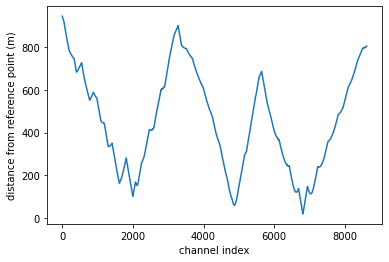

In [12]:
distances = np.sqrt((x-srcX)**2 + (y-srcY)**2)
print('distances (m)')
import matplotlib.pyplot as plt
plt.plot(distances)
plt.xlabel("channel index")
plt.ylabel("distance from reference point (m)")
plt.show()

8650
30


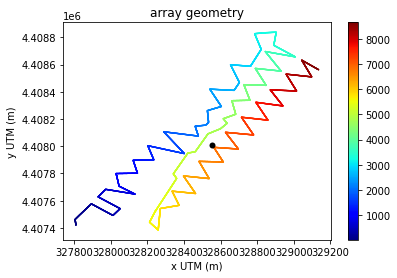

In [14]:
maxCh = np.max(ch)
minCh = np.min(ch)
print(maxCh)
print(minCh)
# location of source from https://gdr.openei.org/submissions/849
# converted to UTM by https://www.latlong.net/lat-long-utm.html
plt.scatter(x,y,c=ch,linewidth=0,s=2,cmap=plt.get_cmap('jet'))
plt.colorbar()
plt.xlabel('x UTM (m)')
plt.ylabel('y UTM (m)')
plt.title('array geometry')
plt.scatter(srcX,srcY,c='k',linewidth=0)
plt.show()

Simple SEG-Y reader (see if this can be replaced with Obspy call possibly?)


In [0]:
nTxtFileHeader = 3200
nBinFileHeader = 400
nTraceHeader = 240
def readTrace(infile,nSamples,dataLen,traceNumber,endian,startSample,nSamplesToRead):
    '''infile is .sgy, nSamples is the number of samples per sensor, and traceNumber is the sensor number (start with 1),dataLen is number of bytes per data sample'''

    fin = open(infile, 'rb') # open file for reading binary mode
    startData = nTxtFileHeader+nBinFileHeader+nTraceHeader+(traceNumber-1)*(nTraceHeader+dataLen*nSamples)+startSample*dataLen
    fin.seek(startData)
    thisDataBinary = fin.read(nSamplesToRead*dataLen) # read binary bytes from file
    fin.close()
    thisDataArray = struct.unpack_from(endian+('f')*nSamplesToRead,thisDataBinary) # get data as a tuple of floats
    return np.asarray(thisDataArray,dtype=np.float32)   

Grab a vibroseis sweep. More info at http://search.geothermaldata.org/dataset/98046653-40ef-4274-96e5-56bb8ae4dbde


In [21]:
!wget https://gdr.openei.org/files/849/PoroTomo_iDAS16043_160325140048.sgy

--2020-04-29 13:35:53--  https://gdr.openei.org/files/849/PoroTomo_iDAS16043_160325140048.sgy
Resolving gdr.openei.org (gdr.openei.org)... 52.32.102.211, 52.24.243.44, 54.148.193.62
Connecting to gdr.openei.org (gdr.openei.org)|52.32.102.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1048616640 (1000M) [application/octet-stream]
Saving to: ‘PoroTomo_iDAS16043_160325140048.sgy’

PoroTomo_iDAS16043_ 100%[===================>]   1000M  8.65MB/s    in 2m 11s  

2020-04-29 13:38:05 (7.61 MB/s) - ‘PoroTomo_iDAS16043_160325140048.sgy’ saved [1048616640/1048616640]



In [0]:
# FIX THE READER ABOVE TO GET THESEE HEADERS AUTOMATICALLY
# but correct file size and timing is acquired by
# 8721 channels (starting with channel id -20 as the 0th channel)
# 1000 samples per second
# 30 seconds
# 4 bytes per sample
nChannels = 8721
samplesPerSecond = 1000
secondsPerRecord = 30
nSamples = samplesPerSecond * secondsPerRecord
bytesPerSample = 4
chNumberFor0thTrace = -20
startTrNumber = minRow # for full array # for one segment do 5275
endTrNumber =  maxRow # for full array # for one segment do 5490 # note, this is assuming trace 0 is ch -20
datafile = "PoroTomo_iDAS16043_160325140048.sgy"


data = np.zeros((endTrNumber-startTrNumber+1,nSamples))
for tr in range(startTrNumber,endTrNumber+1):
	data[tr-startTrNumber,:] = readTrace(datafile, nSamples, bytesPerSample, tr, '>', 0, nSamples)

Plot the response across the full array

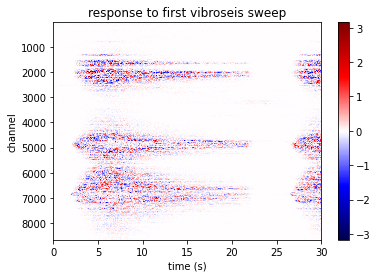

<Figure size 432x288 with 0 Axes>

In [25]:
plt.imshow(data,aspect='auto',extent=(0,secondsPerRecord,endTrNumber+chNumberFor0thTrace,startTrNumber+chNumberFor0thTrace),interpolation='none',cmap=plt.get_cmap('seismic'))
plt.xlabel('time (s)')
plt.ylabel('channel')
plt.title('response to first vibroseis sweep')
plt.colorbar()
plt.show()
plt.clf()

Plot a time snapshot on the geometry at 3.5 seconds (note: could extend this to make a movie)

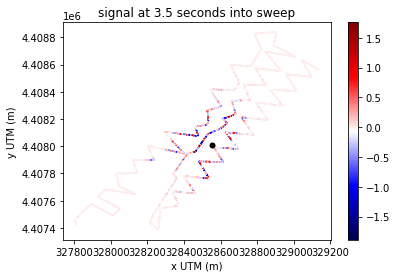

In [32]:
time = 3.5 # in seconds
timeID = int(time*samplesPerSecond)
plt.scatter(x,y,c=data[:,timeID],linewidth=0,s=2,cmap='seismic')
plt.colorbar()
plt.xlabel('x UTM (m)')
plt.ylabel('y UTM (m)')
plt.title('signal at '+str(time)+' seconds into sweep')
plt.scatter(srcX,srcY,c='k',linewidth=0)
plt.show()